In [71]:
import pandas as pd
import torchxrayvision as xrv
import numpy as np
import cv2
from torchsummary import summary
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from collections import Counter
import torchvision
from torchvision import transforms
from torchvision.transforms import Lambda
from torch.utils.data import DataLoader
from torch.optim import Adam,lr_scheduler
import time
import copy
from tqdm import tqdm
from PIL import ImageOps,Image
import glob
from skmultilearn.dataset import load_dataset
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection import iterative_train_test_split

In [72]:
# try:
        
#     my_route = '../../OneDrive/Documents/Documentos/physionet.org/files/mimic-cxr/2.0.0'
#     os.chdir(my_route) 
# except FileNotFoundError:
#     pass

In [73]:
multiclassdf = pd.read_csv('./jpg_images.csv')
multiclassdf.iloc[:,1:] = multiclassdf.iloc[:,1:].astype('int32')

#### 1. Unbalanced Dataset
We can appreciate that the dataset is truly imbalanced. We need to create a datset more balanced. Actually all no findings are checked that are actually labeled. Therefore we can remove randomly no findings 
(Another good option would be removing no finding classes by means of making Anomaly Detection).

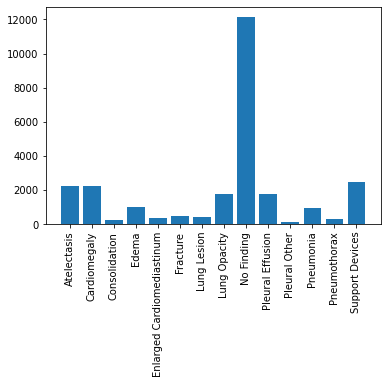

Atelectasis                    2234
Cardiomegaly                   2229
Consolidation                   282
Edema                          1047
Enlarged Cardiomediastinum      354
Fracture                        472
Lung Lesion                     447
Lung Opacity                   1780
No Finding                    12123
Pleural Effusion               1802
Pleural Other                   116
Pneumonia                       971
Pneumothorax                    337
Support Devices                2481
dtype: object

In [74]:
countimages = multiclassdf.sum().iloc[1:]
plt.bar(x = countimages.keys(),height = countimages.values)
plt.xticks(rotation=90)
plt.show()
countimages

In [75]:
# Removing No Finding Data
multiclassdf['No Finding'].sample()

5373    1
Name: No Finding, dtype: int32

In [76]:
# Fraction of No Finding data to drop
positivenormal = (multiclassdf['No Finding'] == 1)
rowsnormals = multiclassdf['No Finding'][multiclassdf['No Finding'] == 1]
# Length of normals 
n_normals = len(rowsnormals)
# Length of fraction that will be remained which is equal to the average of the different label types we have 
fraction = int(multiclassdf.sum().loc[~multiclassdf.columns.isin(['No Finding'])].iloc[1:].mean())
# Dropping no findings observations
drop_no_findings = rowsnormals.sample(n = n_normals-fraction).index
# Drop the columns
multiclassdf = multiclassdf.drop(index=drop_no_findings)

Now is better distributed the samples

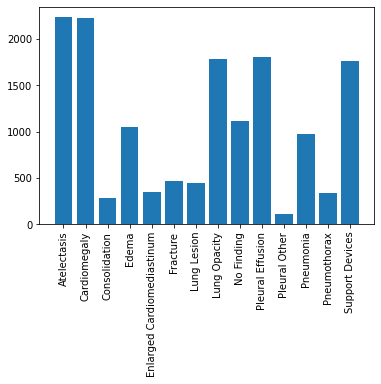

Atelectasis                   2234
Cardiomegaly                  2229
Consolidation                  282
Edema                         1047
Enlarged Cardiomediastinum     354
Fracture                       472
Lung Lesion                    447
Lung Opacity                  1780
No Finding                    1119
Pleural Effusion              1802
Pleural Other                  116
Pneumonia                      971
Pneumothorax                   337
Support Devices               1768
dtype: object

In [77]:
countimages = multiclassdf.sum().iloc[1:]
plt.bar(x = countimages.keys(),height = countimages.values)
plt.xticks(rotation=90)
plt.show()
countimages

###### 1.1 Plotting number of positive labels is identified
We can see that the majority of positive labels are just one label samples.
However we see 2000 observations that have at least two positive labels as well as in an exponential way the number of positive labels there are. 


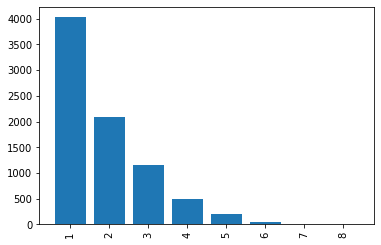

In [78]:
poslabel = multiclassdf.iloc[:,1:].apply(lambda x: sum(x),axis = 1)
countltimes = Counter(poslabel)
x_times = sorted(countltimes.items())

plt.bar(x =[x_times[i][0] for i in range(len(x_times))],height = [x_times[i][1] for i in range(len(x_times))])
plt.xticks(rotation=90)
plt.show()

In [79]:
### Building a multilabel graph
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
edge_map = graph_builder.transform(multiclassdf.iloc[:,1:].to_numpy())
print("{} labels, {} edges".format(len(multiclassdf.columns[1:]), len(edge_map)))
print(edge_map)

14 labels, 78 edges
{(6, 11): 51.0, (1, 4): 65.0, (1, 9): 593.0, (4, 9): 81.0, (1, 12): 58.0, (4, 12): 21.0, (9, 12): 89.0, (9, 11): 167.0, (0, 5): 66.0, (9, 13): 631.0, (12, 13): 172.0, (0, 9): 797.0, (0, 13): 686.0, (0, 1): 560.0, (2, 3): 57.0, (1, 3): 463.0, (1, 7): 361.0, (3, 7): 213.0, (3, 9): 466.0, (7, 9): 442.0, (1, 13): 660.0, (3, 13): 309.0, (7, 13): 441.0, (2, 11): 98.0, (0, 3): 241.0, (0, 7): 570.0, (7, 10): 38.0, (10, 13): 20.0, (5, 9): 41.0, (1, 6): 49.0, (3, 6): 20.0, (6, 7): 163.0, (7, 11): 390.0, (6, 13): 74.0, (11, 13): 117.0, (0, 6): 66.0, (0, 12): 90.0, (6, 12): 13.0, (3, 11): 106.0, (2, 7): 71.0, (0, 10): 9.0, (9, 10): 14.0, (1, 11): 143.0, (2, 9): 134.0, (2, 13): 84.0, (6, 9): 83.0, (0, 4): 88.0, (4, 13): 102.0, (4, 7): 67.0, (4, 10): 3.0, (0, 2): 79.0, (1, 10): 26.0, (0, 11): 188.0, (5, 13): 69.0, (2, 4): 15.0, (3, 4): 36.0, (2, 5): 5.0, (3, 5): 16.0, (4, 5): 10.0, (2, 6): 24.0, (4, 6): 20.0, (8, 13): 88.0, (1, 2): 59.0, (7, 12): 50.0, (6, 10): 8.0, (1, 5): 57.0,

### 2. Initialize data dividing in train validation and test

In [80]:
def concatsplit(X,y):
    '''
    Concat the datframes
    '''
    return pd.concat([X,y],axis=1)
def split(X:np.array,y:np.array,test_size:float = 0.3):
    '''
    Split the dataframe in train and test
    '''

    return iterative_train_test_split(X, y, test_size = test_size)
   
def split_(X:pd.DataFrame,y:pd.Series)->list:
    '''
    Split and concat dataframes
    '''
    # Split procedure
    X_train, y_train, X_val, y_val  = split(X.to_numpy()[...,None], y.to_numpy(),test_size = 0.3)
    X_val, y_val,X_test, y_test = split(X_val, y_val,test_size = 0.5)
    # Concatenation procedure
    train_df = numpytopd(X_train,y_train)
    val_df = numpytopd(X_val,y_val)
    test_df = numpytopd(X_test,y_test)
    return [train_df,val_df,test_df]


def numpytopd(X:np.array,y:np.array)->pd.DataFrame:
    '''
    Map numpy to pandas dataframe
    @param X (np.array): path of the image
    @param y (np.array): labels to classify
    '''
    return pd.DataFrame(np.hstack((X,y)),columns=multiclassdf.columns)


In [81]:
y = multiclassdf[list(multiclassdf.columns)[1:]]
X = multiclassdf['path']

In [82]:
[train_df,val_df,test_df] = split_(X,y)

In [83]:
import plotly.express as px


def balanced_labels_viz(*args:list[pd.DataFrame],title_args:list[str] = None):
        '''
        Plot labels distributions of the dataset
        @ param train_df :train set
        @ param train_df :validation set
        @ param train_df :test set 
        @ title_args : title of the arguments
        '''
        def viz_pie(train_df:pd.DataFrame,title:str = 'train'):
            '''
            Vizuzalize pie distribution of the labels
            @ param train_df (pd.DataFrame) : DataFrame of the labels
            @ param title (pd.DataFrame) : DataFrame of the labels

            '''
            temp = pd.DataFrame(train_df.sum().iloc[1:],columns = ['values'])
            temp['names'] = temp.index
            fig = px.pie(temp, values='values', names='names', title=f'Distribution of the labels for {title} set')
            fig.show()
        # For each of the df_sets we visualize the pie distribution
        if title_args is not None:
            for (arg,title_arg) in zip(args,title_args):
                viz_pie(arg,title=title_arg)
        else:
            for (arg) in args:
                viz_pie(arg)




In [84]:
balanced_labels_viz(*[train_df,val_df,test_df],title_args=['train','val','test'])

### 3.Pytorch
Pytorch is an open source framework written in pytorch used in deep learning fields. We will use it to provide a CNN classification of chest x ray pathologies

In [85]:
os.environ['CUDA_VISIBLE_DEVICES']='0' # pick GPU to use
typedevice = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(typedevice)
print(f'Using {device} device')

Using cpu device


#### 3.1 Definition of the dataset

#### 3.2 Random Augmentation (transforming and manipulating the dataset)
The transformations that we make before inputting on to the train model:
- Applying CLAHE equalization
- Resize the image to 250x250 resolution
- Crop the image to the center 
- Map to a tensor object to run the data in gpu device

In [86]:
class XRayDataset(Dataset):
                '''
                Dataset Class of the images
                '''

                def __init__(self, csvfile,labels = list(multiclassdf.columns)[1:],transform=None, target_transform=Lambda(lambda y: torch.zeros(2, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))):
                    '''
                    @param csvfile (pd.DataFrame) Dataframe where we get the information of input and output parameters
                    @param transform (Transforms) Module to generate transformations on input data
                    @param target_transform (Transforms) Module to generate transformations on target data
                    '''
                    self.img_labels = csvfile 
                    self.transform = transform
                    self.target_transform = target_transform
                    self.labels = labels 
                def check4d(self,image):
                  '''
                  Check if the image has 4 dimensions
                  '''
                  if image.shape[0]==4:
                    return np.expand_dims( image.numpy()[0,...],0)
                  elif image.shape[0]==1:
                    return image
                  else:
                    print('Something weird is happening')
                '''
                This generator returns the length of the dataset
                '''
                def __len__(self):
                    return len(self.img_labels)
                '''
                And this return the input and output terms returned 
                '''
                def __getitem__(self, idx):
                    img_path = self.img_labels.path.iloc[idx]
                    image = ImageOps.grayscale(Image.open(img_path))
                    # ### Check image 4d
                    # image = self.check4d(image)
                    # image = self.clahe.apply(np.array(image))
                    # image = Image.fromarray(image)
                    # label = np.array(self.img_labels.label_num.iloc[idx])
                    label = self.img_labels[self.labels].iloc[idx].values.astype(np.int32)
                    if self.transform:
                        image = self.transform(image)
                    if self.target_transform:
                        label =self.target_transform(label)
                    return image,label
def createdataset(*args,**kwargs):
        '''
        Creates the dataset of the model in a Dataset object
        @param df (pd.DataFrame) :dataframe of the model
        @param transform (Sequential|Transforms)  :module generally used to perform random Augmentation on the input tensor or different transformations
        @param target_transform (Transforms) :module module generally used to perform random Augmentation on the target tensor if specified

        '''
        return XRayDataset(*args,**kwargs)
def createdatasets(train_df,val_df,test_df):
        '''
        Create the datasets with the transformations
        '''
        '''
        Transformation with torchxrayvision transforms
        '''
        train_transform = torchvision.transforms.Compose([transforms.Resize(224), # maybe better to factor out resize step
            transforms.CenterCrop(224),
            transforms.ToTensor()])

        valid_transform = torchvision.transforms.Compose([transforms.Resize(224), # maybe better to factor out resize step
            transforms.CenterCrop(224),
            transforms.ToTensor()])
        test_transform = torchvision.transforms.Compose([transforms.Resize(224), # maybe better to factor out resize step
            transforms.CenterCrop(224),
            transforms.ToTensor()])
        '''
        Dataset Loading with random Augmentation
        '''
        train_dataset = createdataset(train_df,transform=train_transform,target_transform= torch.from_numpy)
        validation_dataset = createdataset(val_df,transform=valid_transform,target_transform= torch.from_numpy)
        test_dataset = createdataset(test_df,transform=test_transform,target_transform =  torch.from_numpy )
        return train_dataset,validation_dataset,test_dataset

In [87]:
train_dataset,validation_dataset,test_dataset = createdatasets(train_df,val_df,test_df)

len(train_dataset)

5678

In [88]:
for (inputs,outputs) in train_dataset:
    print(inputs,outputs)
    break

tensor([[[0.0353, 0.0275, 0.0392,  ..., 0.0667, 0.0627, 0.0588],
         [0.0392, 0.0314, 0.0392,  ..., 0.0706, 0.0706, 0.0627],
         [0.0392, 0.0314, 0.0431,  ..., 0.0706, 0.0784, 0.0824],
         ...,
         [0.6235, 0.6275, 0.6353,  ..., 0.6039, 0.5843, 0.5686],
         [0.6235, 0.6275, 0.6353,  ..., 0.6118, 0.5922, 0.5686],
         [0.6235, 0.6196, 0.6275,  ..., 0.6118, 0.5922, 0.5686]]]) tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0], dtype=torch.int32)


#### 3.3 Transfer Learning
Before training the neural network we want to train we are going to take a pretrained neural network as base_model to start since a good match point.
To make the transfer learning approach we are going to take pretrained weights from chest x ray images from torchxrayvision framework.
The github framework is from the following page:
https://github.com/mlmed/torchxrayvision

In [89]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
print(input)
target =torch.randn(3, 5)
output = loss(input, target)
output.backward()
print(input)
# # Example of target with class probabilities
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.randn(3, 5).softmax(dim=1)
# output = loss(input, target)
# output.backward()

tensor([[ 0.3338,  1.2078, -0.2368, -0.5564, -0.5613],
        [ 0.8044, -1.0997,  0.3746, -0.8377,  0.5209],
        [ 0.0788, -1.5047,  1.4138,  0.7970, -0.9499]], requires_grad=True)
tensor([[ 0.3338,  1.2078, -0.2368, -0.5564, -0.5613],
        [ 0.8044, -1.0997,  0.3746, -0.8377,  0.5209],
        [ 0.0788, -1.5047,  1.4138,  0.7970, -0.9499]], requires_grad=True)


In [90]:
def definemodel(use_summary = True,weights = "densenet121-res224-mimic_nb"):
        '''
        Definition of the model
        '''
        ## Load the mdodel
        model = xrv.models.DenseNet(weights=weights)
        ### Moodifications of the model
        model.op_threshs = None # prevent pre-trained model calibration
        num_ftrs = model.classifier.in_features
        # For MultiLabelSoftMarginLoss
        # model.classifier = nn.Sequential( nn.Linear(in_features=1024, out_features=14),torch.nn.LogSoftmax(dim=1)) #  Change the linear layer since 18 outputs to 2 
        # For CrossentropyLoss
        model.classifier = nn.Linear(in_features=1024, out_features=18) #  Change the linear layer since 18 outputs to 2 
        model = model.to(device)
        if use_summary:
            summary(model,(1,224,224))
        return model
model = definemodel()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
      BatchNorm2d-11           [-1, 96, 56, 56]             192
             ReLU-12           [-1, 96, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]          12,288
      BatchNorm2d-14          [-1, 128,

#### 3.5 Optimization arguments
We stablish the configuration arguments to train the model.
The training is based on a take and test effort but taking into account that.
- The more are the parameters in proportion to the data experience you input to the model, the more possibility you have to overfit the data.
- The less the ratio parameters vs data you have the more possibility your model tends to be underfitted.
- Greater batch size implies having more directed convergence but more effort to make backward propagation batch step.
- Lower batch size implies less directed convergence but less effort to make backward propagation in each batch step.


In [91]:
def data_pin(dataset,**kwargs):
        '''
        Dataset already pinned and collate
        '''
        return DataLoader(dataset,**kwargs)
def configure_performance_data(train_dataset,validation_dataset,test_dataset,pin_memory = True,n_workers = None,prefecth_factor = 3,batch_size = 16):
       '''
       Configure the dataset for model peformance
       '''
       train_data_loader = data_pin(train_dataset, batch_size=batch_size, shuffle=True,pin_memory=pin_memory,num_workers = n_workers//2,prefetch_factor = prefecth_factor)
       valid_data_loader = data_pin(validation_dataset, batch_size=batch_size, shuffle=False,pin_memory=pin_memory,num_workers = n_workers//2,prefetch_factor = prefecth_factor)
       test_dataloader = data_pin(test_dataset, batch_size=batch_size, shuffle=False,pin_memory=pin_memory,num_workers = n_workers-1,prefetch_factor = prefecth_factor)
       return train_data_loader,valid_data_loader,test_dataloader


In [92]:
torch.backends.cudnn.benchmark = True
# Batch of data you take for each training step
batch_size = 12
# N_workers on the cpu
n_workers = 1
# Type of memory pinning you use
pin_memory = False
train_data_loader = data_pin(train_dataset, batch_size=batch_size, shuffle=False,pin_memory=pin_memory)
valid_data_loader = data_pin(validation_dataset, batch_size=batch_size, shuffle=False,pin_memory=pin_memory)
test_dataloader = data_pin(test_dataset, batch_size=batch_size, shuffle=False,pin_memory=pin_memory)
# Size of training | validation and test set
test_data_size = len(test_dataset); valid_data_size = len(validation_dataset);train_data_size = len(train_dataset)
# Define Optimizer and Loss Function
optimizer = Adam(model.parameters(),lr=0.0000375)
loss_func = torch.nn.MultiLabelSoftMarginLoss().to(device)
# loss_func = nn.NLLLoss().to(device)
# optimizer = Adam(model.parameters(),lr=0.0000375)
# # Learning rate scheduler | change by a factor of 0.1 per patience steps
patience = 3
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,patience=patience ,factor=0.1)

#### 3.6 Training model
This part executes the training step where the model acquires experience to be evaluated afterwards.

In [93]:
import plotly.express as px
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss





def train_and_validate(model, loss_criterion, optimizer, epochs=25,path = './results/checkpoint.pt',lr_scheduler = None,patience:int = 3):
    '''
    Function to train and validate
    Parameters
        :param model (torch.nn.Model): Model to train and validate
        :param loss_criterion (torch.nn.Loss): Loss Criterion to minimize
        :param optimizer  (torch.nn.optimizer): Optimizer for computing gradients
        :param epochs int: Number of epochs (default=25)
        :param path (str): path where the model must be saved
        :param lr_scheduler (torch.nn.scheduler) : change rate in learning rate
        :param patience (int) : change rate in learning rate
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0
    # Use of Early Stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True,path = path)
    # For each of the epochs
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        # Set to training mode
        model.train()
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        # For each of the batches
        for i, (inputs,labels) in enumerate(tqdm(train_data_loader,0)):
            # X,y to cuda device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Forward pass - compute outputs on input data using the model    
            outputs = model(inputs)
            # Computing the loss function
            loss = loss_criterion(outputs, labels)  
            # Backward propagation
            loss.backward()
            # Update the optimizer 
            optimizer.step()
            optimizer.zero_grad()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            # # Get the predictions which maximizes the element of outputs vector
            # ret, predictions = torch.max(outputs.data, 1)
            # # Sum the correct counts
            # correct_counts = predictions.eq(labels.data.view_as(predictions))
            # # Convert correct_counts to float and then compute the mean
            # acc = torch.mean(correct_counts.type(torch.FloatTensor))
            # # Compute total accuracy in the whole batch and add to train_acc
            # train_acc += acc.item() * inputs.size(0)
            ## Printing out info (deprecated)
            # print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
        # Validation - No gradient tracking needed
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()
            # Validation loop
            for j, (inputs,labels) in  enumerate(valid_data_loader):
            
               
                # X,y to cuda device
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)
                # Computing the loss function
                loss = loss_criterion(outputs, labels)
                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)
                # Calculate validation accuracy
                # ret, predictions = torch.max(outputs.data, 1)
                # correct_counts = predictions.eq(labels.data.view_as(predictions))
                # # Convert correct_counts to float and then compute the mean
                # acc = torch.mean(correct_counts.type(torch.FloatTensor))
                # # Compute total accuracy in the whole batch and add to valid_acc
                # valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
            
        # # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        # avg_train_acc = train_acc/train_data_size

        # # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        # avg_valid_acc = valid_acc/valid_data_size
        
        # Pass to next scheduler
        lr_scheduler.step(avg_valid_loss)
        # Early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%".format(epoch+1, avg_train_loss, -1, avg_valid_loss, -1))
        history.append([avg_train_loss, avg_valid_loss, None,None])
    epoch_end = time.time()
    print("Time: {:.4f}s".format( epoch_end-epoch_start))
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(path))
    return model, history
def stackhistory(history):
    '''
    Stack historical response
    @ param history (list of lists) : list of information got in the model (losses,precision,fbeta,...)
    '''
    return np.hstack((np.array(history),np.array([i for i in range(1,len(history)+1)])[:,None]))
def plothistory(history):
    '''
    Plot the history of the model
    '''
    history = stackhistory(history)
    history = pd.DataFrame(data = history,columns = ['train_loss','val_loss','train_acc','val_acc','epochs'])
    fig = px.line(history, x='epochs', y="val_loss",width=900,height=800)
    fig.data[0].name= "val_loss"
    fig.update_traces(showlegend=True)
    fig.add_scatter(x=history['epochs'], y=history['train_loss'],name = "train_loss")
    fig.show()
    

In [94]:
# model, history = train_and_validate(model, loss_func, optimizer, path = './checkpoint_ch_ce.pt', epochs=25,lr_scheduler = scheduler,patience = patience) 

In [95]:

# torch.backends.cudnn.benchmark = True
# use_summary = False
# # Batch of data you take for each training step
# batch_size = 12
# # N_workers on the cpu
# n_workers = 1
# # Type of memory pinning you use
# pin_memory = False
# train_data_loader = data_pin(train_dataset, batch_size=batch_size, shuffle=False,pin_memory=pin_memory)
# valid_data_loader = data_pin(validation_dataset, batch_size=batch_size, shuffle=False,pin_memory=pin_memory)
# test_dataloader = data_pin(test_dataset, batch_size=batch_size, shuffle=False,pin_memory=pin_memory)
# # Size of training | validation and test set
# test_data_size = len(test_dataset); valid_data_size = len(validation_dataset);train_data_size = len(train_dataset)
# # Define Optimizer and Loss Function
# loss_func = nn.MultiLabelSoftMarginLoss().to(device)
# # Learning rate scheduler | change by a factor of 0.1 per patience steps
# patience = 3

# def trainmodels(lr =4.090909090909091e-05,
#                 factor = 0.1 ,
#                 epochs = 25,
#                 use_summary = None,
#                 ckpoints = ['densenet121-res224-all','densenet121-res224-rsna','densenet121-res224-nih','densenet121-res224-pc','densenet121-res224-chex','densenet121-res224-mimic_ch'],
#                 ):
#         '''
#         For loop to train several models
#         '''
#         histories = []
#         for weights in ckpoints:
#             model = definemodel(use_summary=use_summary,weights=weights)
#             optimizer = Adam(model.parameters(),lr=lr)
#             scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,patience=patience ,factor=factor)
#             base_name = weights.split('-')[-1]
#             path = f'./{base_name}.pt'
#             history = train_and_validate(model, loss_func, optimizer, path = path, epochs=epochs,lr_scheduler = scheduler) 
#             histories.append(history[1])
#         return histories
# histories = trainmodels( ckpoints = ['densenet121-res224-all'])

# import pickle
# with open('histories_mc.pickle', 'wb') as f:
#     pickle.dump(histories, f)

In [96]:
import pickle 
with open('histories_mc.pickle', 'rb') as f:
    histories = pickle.load(f)
for history in histories:
    plothistory(history=history)

#### 3.7 Evaluating the performance
Once the model is trained, we are going to evaluate the performance of the model trained

In [97]:
def definemodel(use_summary = False,weights = "densenet121-res224-mimic_nb"):
        '''
        Definition of the model
        '''
        ## Load the mdodel
        model = xrv.models.DenseNet(weights=weights)
        ### Moodifications of the model
        model.op_threshs = None # prevent pre-trained model calibration
        num_ftrs = model.classifier.in_features
        # For MultiLabelSoftMarginLoss
        # model.classifier = nn.Sequential( nn.Linear(in_features=1024, out_features=14),torch.nn.LogSoftmax(dim=1)) #  Change the linear layer since 18 outputs to 2 
        # For CrossentropyLoss
        model.classifier = nn.Linear(in_features=1024, out_features=14) #  Change the linear layer since 18 outputs to 2 
        model = model.to(device)
        if use_summary:
            summary(model,(1,224,224))
        return model

In [98]:
def loadmodel(path:str,weights:str = 'densenet121-res224-mimic_nb')->object:
    '''
    Return the model make
    @param path (str): path of the model
    @param weights (str): weights of the pretrained model used
    '''
    model = definemodel(weights=weights)
    model.load_state_dict(torch.load(f'{path}',map_location=device))
    return model


model = loadmodel('checkpoint_ch_ce.pt',weights = 'densenet121-res224-mimic_nb')
  
    
# model = definemodel(weights='densenet121-res224-mimic_ch')

In [99]:
from sklearn.metrics import confusion_matrix,auc,roc_curve
import plotly.graph_objects as go
def test_data_multiclass(model,test_dataloader,numClasses = 14,test_datasize:int = None)->list:

    '''
    Code to get the outputs_and labels of the model to check the performance in later steps
    @param model (torch.nn.Model) : model already trained to be tested 
    @param test_dataloader (torch.nn.DataLoader): object to store the dataset on pytorch
    @numClasses (int): number of classes of the target output (default 2)
    @test_datasize (int): number of classes of the target output (default 2)
    ##### RETURNS
    @param outputs_m (np.array) : probabilities of the output labels
    @param labels_m (np.array) : true labels of the model

    '''
    # Put model in evaluation to disable batch normalization and also dropout
    model.eval()
    contSamples=0
    outputs_m = np.zeros((test_datasize,numClasses))
    labels_m = np.zeros((test_datasize,numClasses))
    # We iterate by each of the test set
    for j, (inputs,labels) in  enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        results = model(inputs)
        # Batch in which you are
        # Pass thrpugh a sigmoid all the results
        sigs = torch.nn.functional.sigmoid(results)
        # Batch size
        batchSize = inputs.shape[0]
        # get the probability predictions and true labels
        outputs_m [contSamples:contSamples+batchSize,...]=sigs.data.cpu().numpy()
        labels_m [contSamples:contSamples+batchSize,...]=labels.data.cpu().numpy()
        contSamples+=batch_size
    return outputs_m,labels_m
def plot_auc(labels_m:np.array,outputs_m:np.array,names:list = list(train_df.columns)[1:]):
        '''
        Plot AUC curve
        @param labels_m (np.array) :  true labels obtained
        @param outputs_m (np.array) :  probabilities of the result obtained
        @param names (list): name of the targets
        '''
        
        fig = go.Figure()
        fig.add_shape(type = 'line',
                    line = dict(dash = 'dash'),
                    x0 = 0,x1 = 1,y0 = 0,y1 = 1)
        for (name,i) in zip(names,list(range(labels_m.shape[1]))):
            y_pred = outputs_m[:,i]
            y_true = labels_m[:,i]
            fpr, tpr, thresholds_keras = roc_curve(y_true,y_pred)
            AUC = auc(fpr, tpr)
            name = f'AUC :  {round(AUC,2)} - {name}'
            fig.add_trace(go.Scatter(x = fpr,y = tpr,name =name,mode = 'lines'))
        fig.update_layout(xaxis_title = 'False Positive Rate',yaxis_title = 'True Positive Rate',
                        yaxis = dict(scaleanchor = 'x',scaleratio = 1),
                        xaxis = dict(constrain = 'domain'),
                        width = 700,height = 500,
                        title = 'AUC of the model evaluated'
                        )
        fig.show()
        return fig
'''
Optimal thresholds finding
'''

from IPython.display import display
def evaluatethresh(labels_m:np.array,outputs_m:np.array,names:list)->dict:
        '''
        Evaluate the threshold regarding each of the label and get the optimum threshold where to cut
        @param labels_m (np.array) : labels of the model
        @param outputs_m (np.array) : probability of the model names
        @param names (list) : names of the labels
        # Returns the dictionary with optimal thresholds and more information
        '''
        threshold = list(map(lambda x: x/1000.0, range(0, 1000, 10)))
        index= np.arange(len(threshold))
        cols = ['threshold', 'accuracy', 'precision', 'recall', 'VPN', 'specifity','f1_score','name']
        thr_list = []
        
        for (name,col) in zip(names,list(range(labels_m.shape[1]))):
                    # Initialize opt_thresh dataframe
                    y_pred = outputs_m[:,col]
                    y_true = labels_m[:,col]
                    opt_thres=pd.DataFrame(index=index, columns = cols)
                    for i in range(len(list(threshold))):
                    
                        y_pred_prob = (y_pred > threshold[i])
                        matrix = confusion_matrix(y_true, y_pred_prob)
                        cf = pd.DataFrame(matrix, range(2), range(2))
                        cf = cf.to_numpy()
                        accuracy  = np.trace(cf) / float(np.sum(cf))
                        precision = cf[1,1] / sum(cf[:,1])
                        recall    = cf[1,1] / sum(cf[1,:])
                        VPN       = cf[0,0] / sum(cf[:,0])
                        specifity = cf[0,0] / sum(cf[0,:])
                        f1_score  = 2*precision*recall / (precision + recall)
                        opt_thres.loc[i] = pd.Series({'threshold':threshold[i], 'accuracy':accuracy, 'precision':precision, 'recall' : recall,
                                                        'VPN':VPN, 'specifity':specifity,'f1_score':f1_score,'name':name })
                    # Display optimal threshold
                    # display(opt_thres)
                    # break
                    optimal_thresh = opt_thres['threshold'][opt_thres['f1_score'] == opt_thres['f1_score'].max()].values[0]
                    thr_list.append(optimal_thresh)
        return {'threshold_list':thr_list,'names':names}

# return opt_thres,AUC

In [104]:
names = list(train_df.columns)[1:]
# Outputs + Labels to detect 
outputs_m,labels_m = test_data_multiclass(model,valid_data_loader,numClasses = 14,test_datasize =  valid_data_size)


In [ ]:
# Return the AUC of the model
plot_auc(labels_m,outputs_m,names = names)
info_eval = evaluatethresh(labels_m,outputs_m,names)

In [ ]:
'''
TEST the model 
'''
import seaborn as sns
def plot_conf_matrix(cf:np.array,ax:object,name:str,*args):
        '''
        Plot confusion matrix one vs all of all labels
        @ param cf (np.array) : conusion matrix of the model
        @ param ax (AxesSubplot) : ax of the model name
        @ param name (str) : name of the label
        @ param *args (list) : arguments of the model
        '''
        '''
        Plot conf matrix
        '''
        xticklabels=['all',name] ; yticklabels=xticklabels
        sns.heatmap(cf,annot = True,cmap = plt.cm.Blues,yticklabels=yticklabels,xticklabels=xticklabels,ax = ax)
        stats_text = "\n\nAccuracy={:0.3f}\nPrecision(VPP)={:0.3f}\nRecall={:0.3f}\nVPN={:0.3f}\nSpecifity{:0.3}\nF1 Score={:0.3f}".format(
                       *args)
        ax.set_ylabel('True label', fontsize=18)
        ax.set_xlabel('Predicted label' + stats_text, fontsize=18)

def conf_matrix_ev(labels_m:np.array,outputs_m:np.array,threshold:list = None,names:list = list(train_df.columns)[1:])->pd.DataFrame:
        '''
        Confusion Matrix evaluation of one vs all for every of the labels
        @param labels_m (np.array) : labels of the model
        @param outputs_m (np.array) : probability of the model names
        @param names (list) : names of the labels
        @param threshold (list) : optimal list

        # Returns the dictionary with optimal thresholds and more information
        '''
 
      
        cols = ['threshold', 'accuracy', 'precision', 'recall', 'VPN', 'specifity','f1_score','name']
        opt_thres=pd.DataFrame(index=np.arange(0,len(names)), columns = cols)
        for i,(name,col) in enumerate(zip(names,list(range(labels_m.shape[1])))):
                            # Initialize opt_thresh dataframe
                            y_pred = outputs_m[:,col]
                            y_true = labels_m[:,col]
                            fig,axs = plt.subplots(1,1,figsize = (10,10))
                                
                           
                            y_pred_prob = (y_pred > threshold[i])
                            matrix = confusion_matrix(y_true, y_pred_prob)
                            cf = pd.DataFrame(matrix, range(2), range(2))
                            cf = cf.to_numpy()
                            accuracy  = np.trace(cf) / float(np.sum(cf))
                            precision = cf[1,1] / sum(cf[:,1])
                            recall    = cf[1,1] / sum(cf[1,:])
                            VPN       = cf[0,0] / sum(cf[:,0])
                            specifity = cf[0,0] / sum(cf[0,:])
                            f1_score  = 2*precision*recall / (precision + recall)
                            metrics = [accuracy,precision,recall,VPN,specifity,f1_score]
                            plot_conf_matrix(cf,axs,name,*metrics)
                            opt_thres.loc[i] = pd.Series({'threshold':threshold[i], 'accuracy':accuracy, 'precision':precision, 'recall' : recall,
                                                            'VPN':VPN, 'specifity':specifity,'f1_score':f1_score,'name':name })
                            fig.show()
        return opt_thres

In [69]:
# Test the unseen model
test_outputs,test_labels = test_data_multiclass(model,test_dataloader,numClasses = 14,test_datasize = test_data_size)

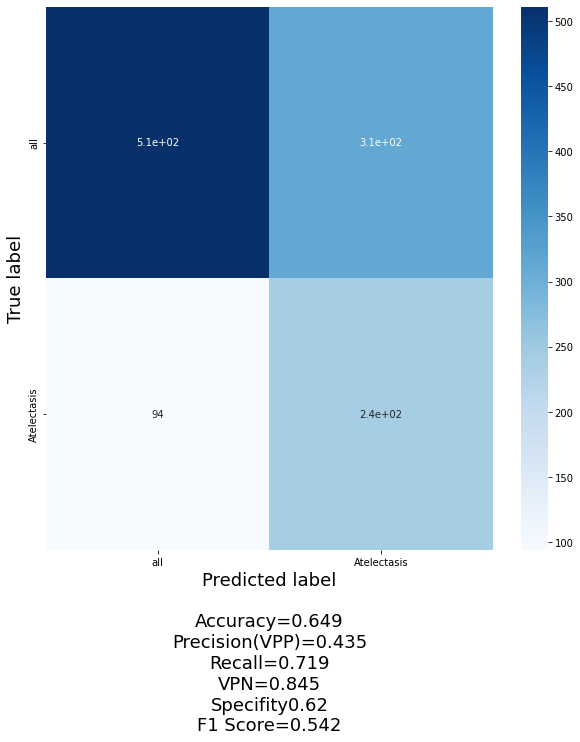

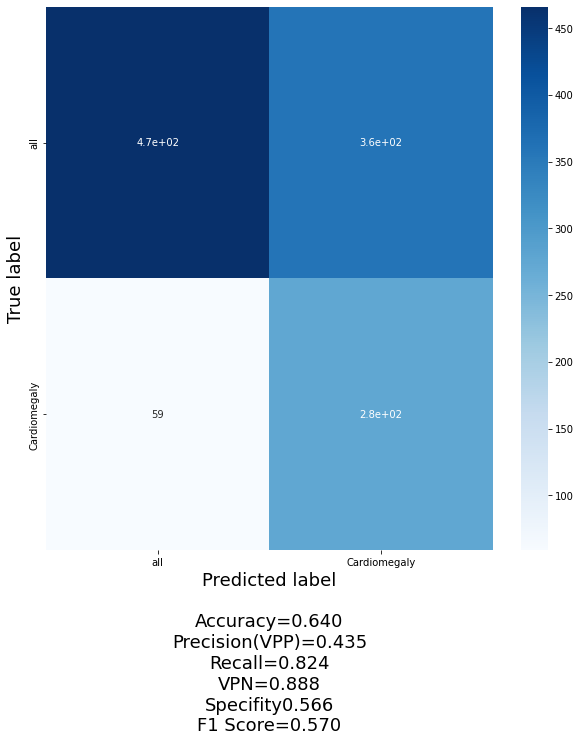

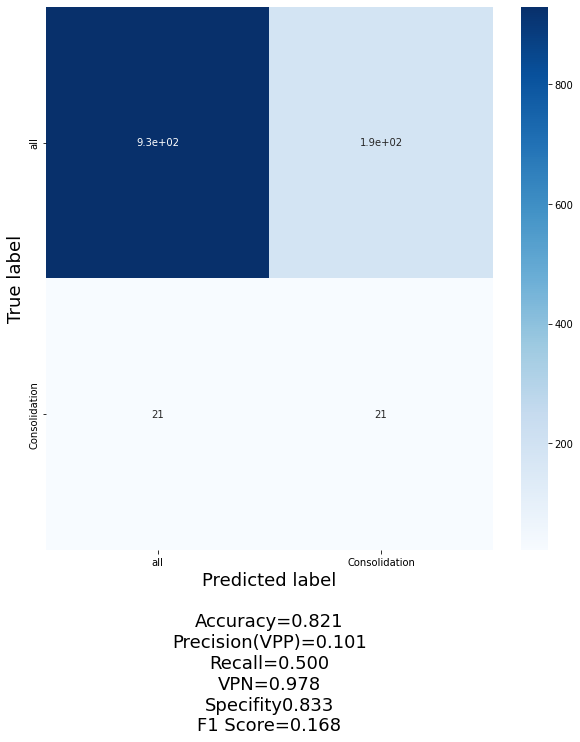

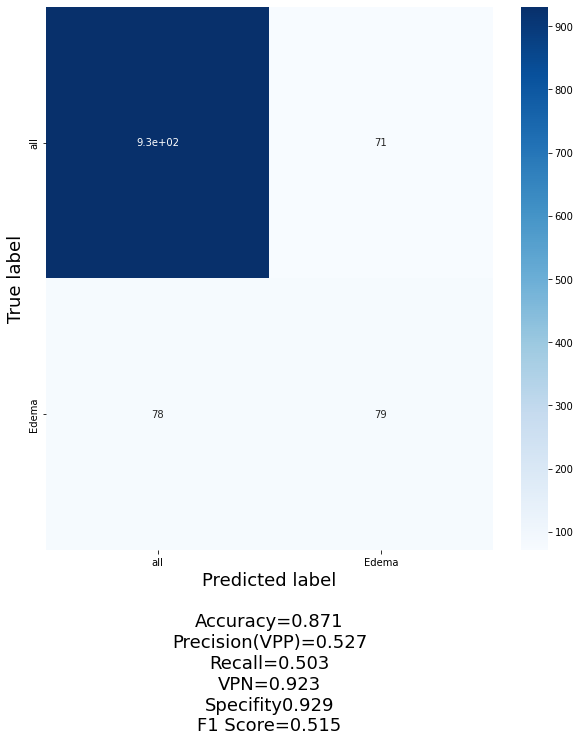

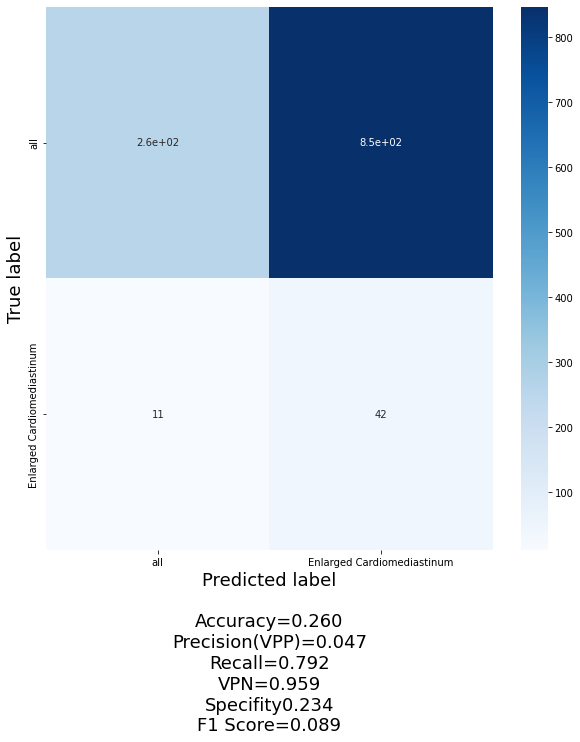

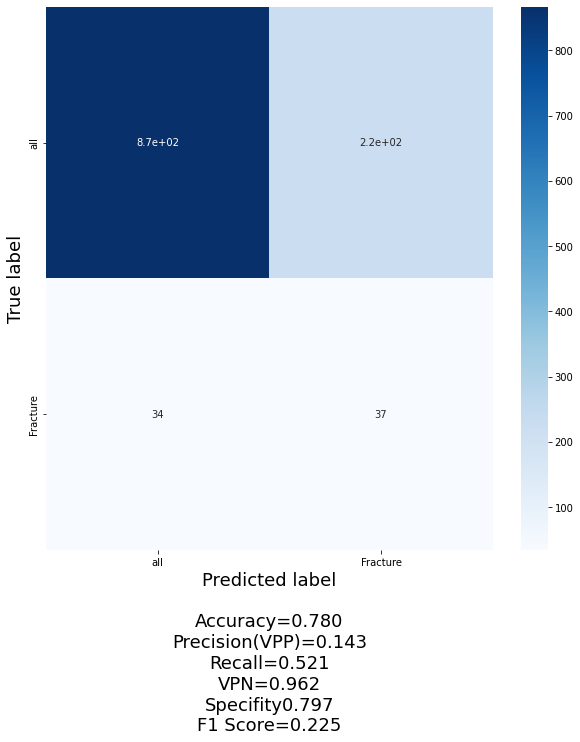

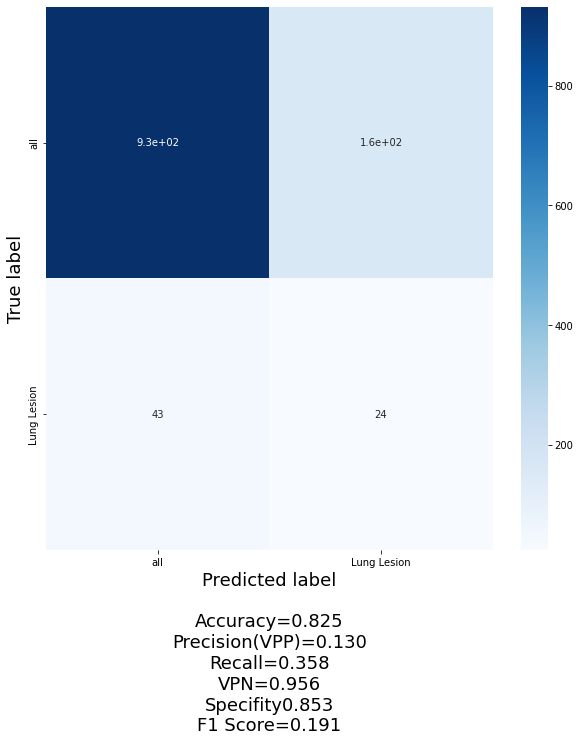

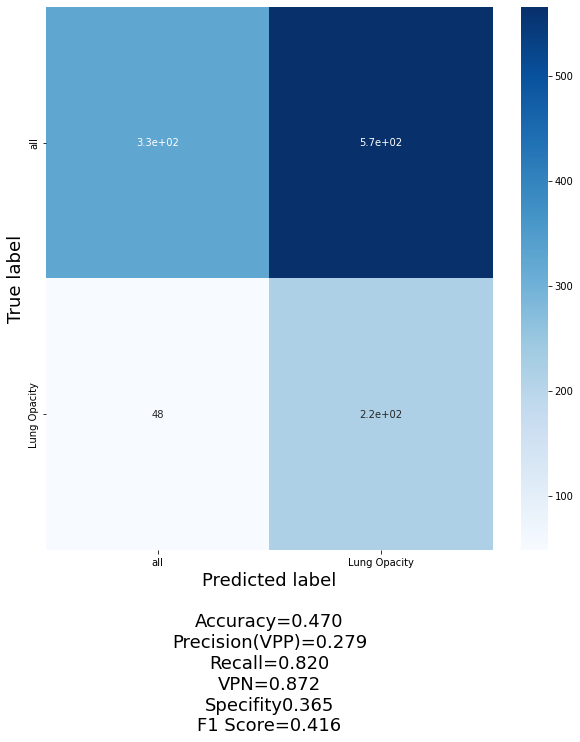

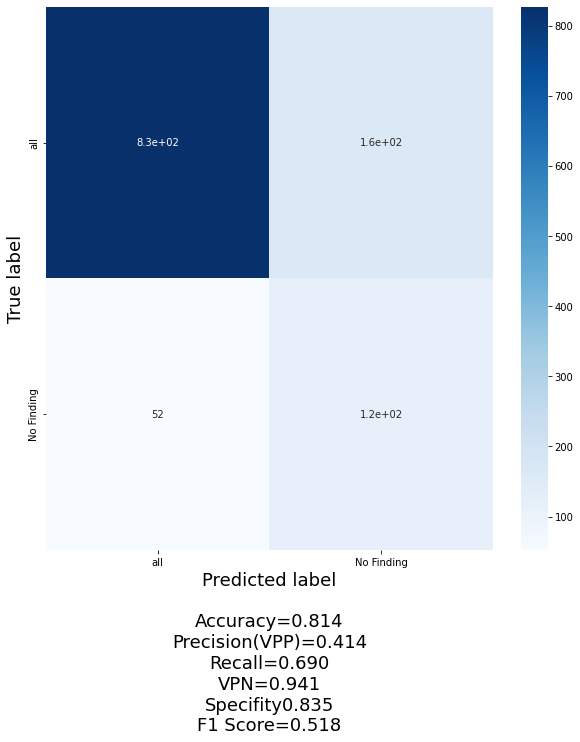

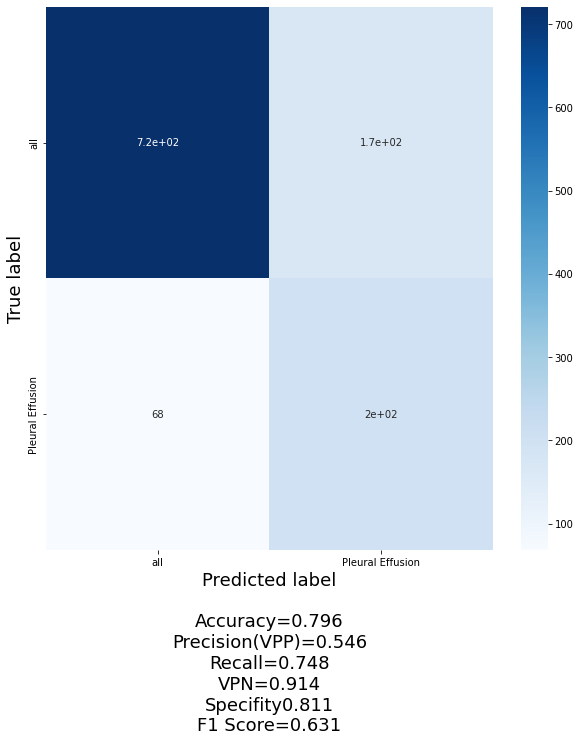

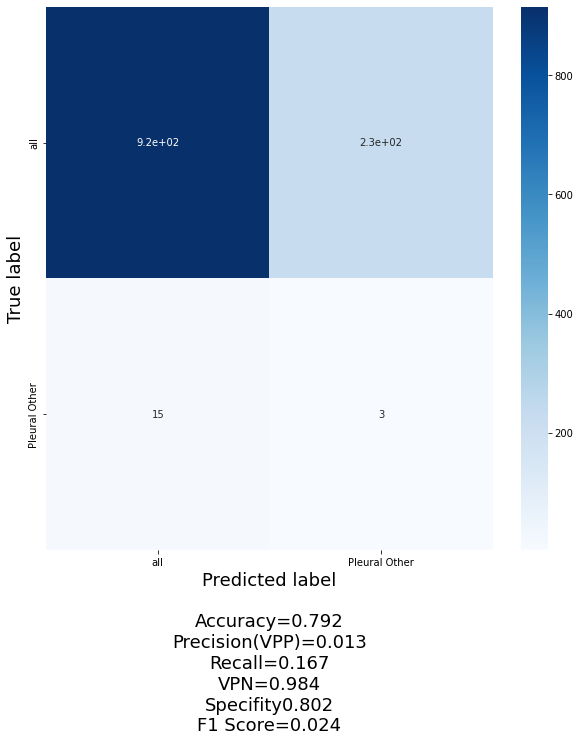

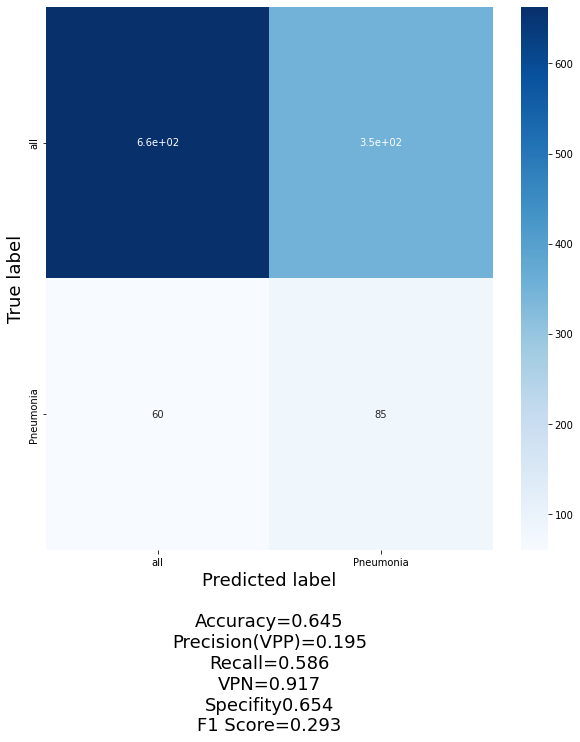

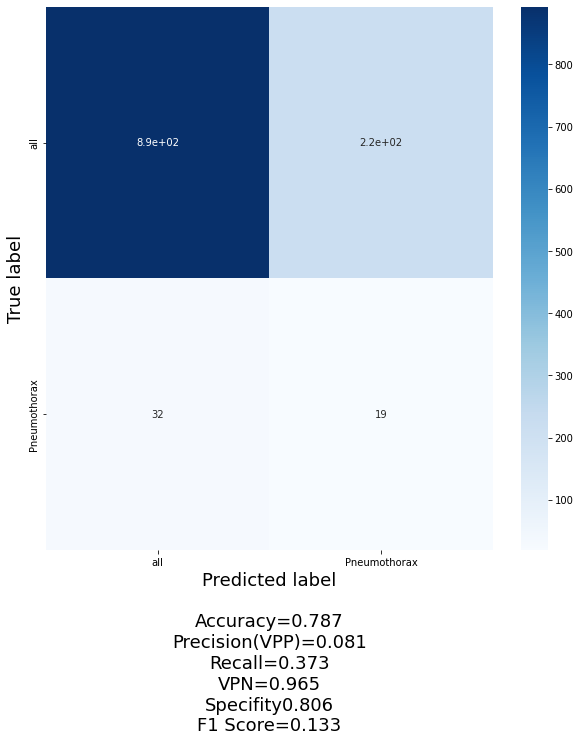

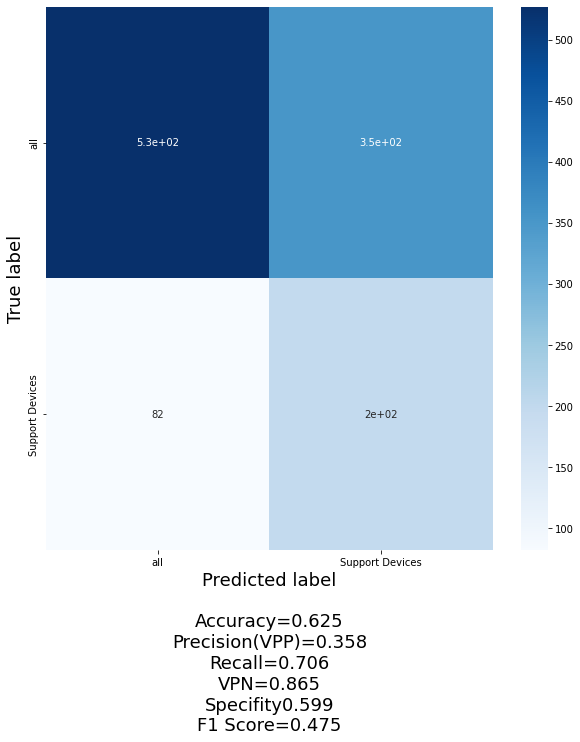

In [70]:
opt_thres = conf_matrix_ev(test_labels,test_outputs,threshold = info_eval['threshold_list'])
  

In [103]:
import pickle 
# Store data (serialize)
with open('opt_mlt_thresh.pickle', 'wb') as handle:
    pickle.dump(opt_thres[['name','threshold']], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [106]:
opt_thres['name']

0                    Atelectasis
1                   Cardiomegaly
2                  Consolidation
3                          Edema
4     Enlarged Cardiomediastinum
5                       Fracture
6                    Lung Lesion
7                   Lung Opacity
8                     No Finding
9               Pleural Effusion
10                 Pleural Other
11                     Pneumonia
12                  Pneumothorax
13               Support Devices
Name: name, dtype: object

------------------------------------------------------------